# Classifying cyberbullism


## Start Spark Session

In [1]:
import os

In [2]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("vectorizer").getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=vectorizer>

## Load the dataset

In [7]:
dname = "cyberbullying_tweets.csv"
datapath = os.path.join(os.environ['BIGLAB'], 'datasetsArmano', 'LabProject')

In [8]:
df = spark.read.csv(os.path.join(datapath, dname), inferSchema=True, header=True, escape='"', maxColumns=2,
                    multiLine=True)
df.show()

+--------------------+------------------+
|          tweet_text|cyberbullying_type|
+--------------------+------------------+
|In other words #k...| not_cyberbullying|
|Why is #aussietv ...| not_cyberbullying|
|@XochitlSuckkks a...| not_cyberbullying|
|@Jason_Gio meh. :...| not_cyberbullying|
|@RudhoeEnglish Th...| not_cyberbullying|
|@Raja5aab @Quicki...| not_cyberbullying|
|Itu sekolah ya bu...| not_cyberbullying|
|Karma. I hope it ...| not_cyberbullying|
|@stockputout ever...| not_cyberbullying|
|Rebecca Black Dro...| not_cyberbullying|
|@Jord_Is_Dead htt...| not_cyberbullying|
|The Bully flushes...| not_cyberbullying|
|         Ughhhh #MKR| not_cyberbullying|
|RT @Kurdsnews: Tu...| not_cyberbullying|
|Love that the bes...| not_cyberbullying|
|@yasmimcaci @Bfer...| not_cyberbullying|
|@sarinhacoral @Vi...| not_cyberbullying|
|@0xabad1dea @kels...| not_cyberbullying|
|Best pick up line...| not_cyberbullying|
|Now I gotta walk ...| not_cyberbullying|
+--------------------+------------

In [9]:
df.count()

47692

In [10]:
df.printSchema()

root
 |-- tweet_text: string (nullable = true)
 |-- cyberbullying_type: string (nullable = true)



In [11]:
for col in df.columns:
    print(col + ': ', df[df[col].isNull()].count())


tweet_text:  0
cyberbullying_type:  0


In [12]:
df.describe().show()

+-------+--------------------+------------------+
|summary|          tweet_text|cyberbullying_type|
+-------+--------------------+------------------+
|  count|               47692|             47692|
|   mean|                null|              null|
| stddev|                null|              null|
|    min| &amp; you might ...|               age|
|    max|😘 http://t.co/2Q...|          religion|
+-------+--------------------+------------------+



In [13]:
from pyspark.sql.functions import *

df.select(countDistinct("cyberbullying_type")).show()

+----------------------------------+
|count(DISTINCT cyberbullying_type)|
+----------------------------------+
|                                 6|
+----------------------------------+



In [14]:
df.select(countDistinct("tweet_text")).show()

+--------------------------+
|count(DISTINCT tweet_text)|
+--------------------------+
|                     46017|
+--------------------------+



In [15]:
df = df.dropDuplicates(["tweet_text"])
df.count()

46017

# StringIndexer

In [16]:
from pyspark.ml.feature import StringIndexer

In [17]:
indexed = StringIndexer(inputCol="cyberbullying_type", outputCol="cyberbullying_type_ndx", handleInvalid='skip').fit(
    df).transform(df)  #


In [18]:
import pandas as pd

df_pandas = df.toPandas()
df_pandas.describe()

,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,&amp; you might not get ya bitch back &amp; t...,religion
freq,1,7995


In [19]:
sorted(indexed.groupBy(['cyberbullying_type_ndx', indexed.cyberbullying_type]).count().collect())

[Row(cyberbullying_type_ndx=0.0, cyberbullying_type='religion', count=7995),
 Row(cyberbullying_type_ndx=1.0, cyberbullying_type='age', count=7992),
 Row(cyberbullying_type_ndx=2.0, cyberbullying_type='ethnicity', count=7952),
 Row(cyberbullying_type_ndx=3.0, cyberbullying_type='not_cyberbullying', count=7937),
 Row(cyberbullying_type_ndx=4.0, cyberbullying_type='gender', count=7898),
 Row(cyberbullying_type_ndx=5.0, cyberbullying_type='other_cyberbullying', count=6243)]

# Data cleansing: tokenization and stopword removal

In [20]:
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover


In [21]:
tokenizer = RegexTokenizer(pattern="[^a-zA-Z0-9]", inputCol='tweet_text', outputCol='token_text')

In [22]:
tokenized = tokenizer.transform(indexed)

In [23]:
tokenized.show()

+--------------------+-------------------+----------------------+--------------------+
|          tweet_text| cyberbullying_type|cyberbullying_type_ndx|          token_text|
+--------------------+-------------------+----------------------+--------------------+
| &amp; you might ...|             gender|                   4.0|[amp, you, might,...|
|  I fucking hate you|             gender|                   4.0|[i, fucking, hate...|
| Keeks is a bitch...|             gender|                   4.0|[keeks, is, a, bi...|
| Murda Gang bitch...|other_cyberbullying|                   5.0|[murda, gang, bit...|
| bitch plz whatever |             gender|                   4.0|[bitch, plz, what...|
| cant you see the...|             gender|                   4.0|[cant, you, see, ...|
| her pussy lips l...|             gender|                   4.0|[her, pussy, lips...|
| if you aint bout...|          ethnicity|                   2.0|[if, you, aint, b...|
| it aint nothing ...|             gender| 

In [24]:
tokenized.schema.names

['tweet_text', 'cyberbullying_type', 'cyberbullying_type_ndx', 'token_text']

In [25]:
tokenized.select("token_text").show(6, truncate=False)

+----------------------------------------------------------------------------------------------------+
|token_text                                                                                          |
+----------------------------------------------------------------------------------------------------+
|[amp, you, might, not, get, ya, bitch, back, amp, thats, that]                                      |
|[i, fucking, hate, you]                                                                             |
|[keeks, is, a, bitch, she, curves, everyone, lol, i, walked, into, a, conversation, like, this, smh]|
|[murda, gang, bitch, its, gang, land]                                                               |
|[bitch, plz, whatever]                                                                              |
|[cant, you, see, these, hoes, wont, change]                                                         |
+------------------------------------------------------------------------

### Remove tweets with length 0 and 1

In [26]:
tokenized2 = tokenized.filter(size(tokenized.token_text) > 1)#returns the length of the array in the column.
tokenized2 = tokenized.filter(size(tokenized.token_text) < 280) #max tweet lenght
print('Before: ', tokenized.count(), 'Now: ', tokenized2.count())


Before:  46017 Now:  46010


# Stopwords removal ("english")

In [27]:
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english', "null")
english_stopwords.extend(['http', 'don', 'aren', 'll', 'will', 'im', 'u']) # 'rt', 'mkr', 'didn', 'bc', 'n', 'm',
# 'im', 'll', 'y', 've', 'u', 'ur', 'don',
#'p', 't', 's', 'aren', 'kp', 'o', 'kat',
# 'de', 're', 'amp', 'will'])

In [28]:
stopremover = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens', stopWords=english_stopwords)


In [29]:
cleaned = stopremover.transform(tokenized2)

In [30]:
cleaned2 = cleaned.filter(size(cleaned.stop_tokens) > 1)  #returns the length of the array in the column.
print('Before: ', cleaned.count(), 'Now: ', cleaned2.count())


Before:  46010 Now:  45745


## Explorative analysis


<AxesSubplot:ylabel='Count'>

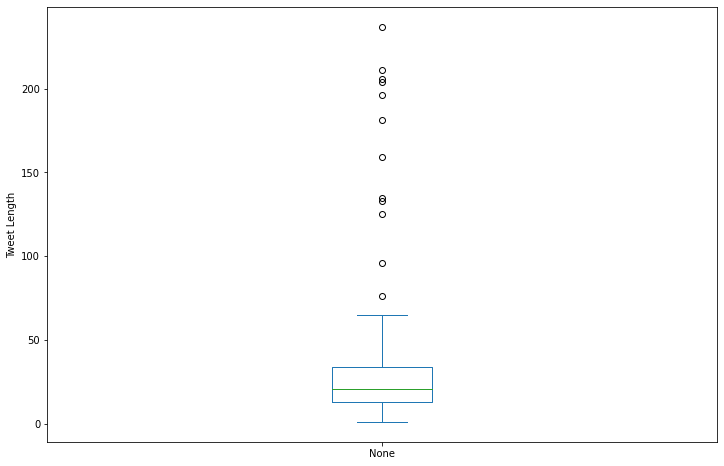

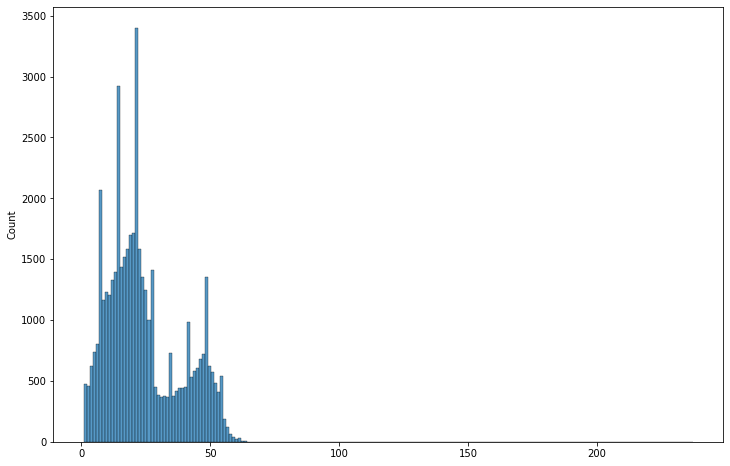

In [31]:
# Calculating tweet length
import seaborn as sns
from matplotlib import pyplot as plt

df_pandas_cleaned= cleaned2.toPandas()

tweet_len = pd.Series([len(tweet.split()) for tweet in df_pandas_cleaned["tweet_text"]])
plt.figure(figsize=(12, 8))
tweet_len.plot(kind="box")
plt.ylabel("Tweet Length")

plt.figure(figsize=(12, 8))
sns.histplot(tweet_len)

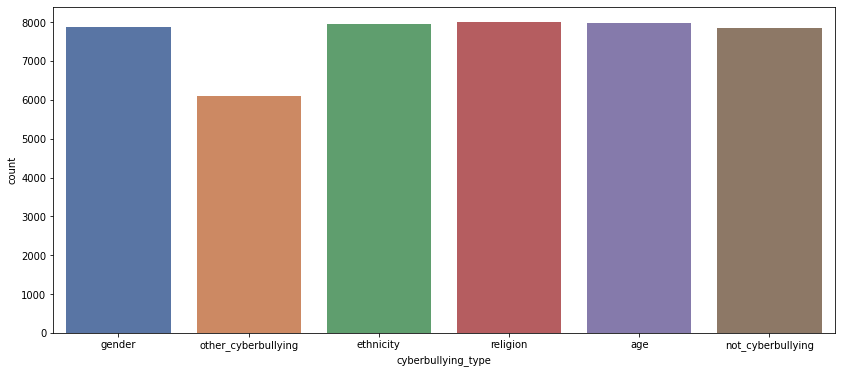

In [32]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14, 6))
sns.countplot(x='cyberbullying_type', data=df_pandas_cleaned, palette='deep')
plt.show()


In [33]:

#pip install wordcloud

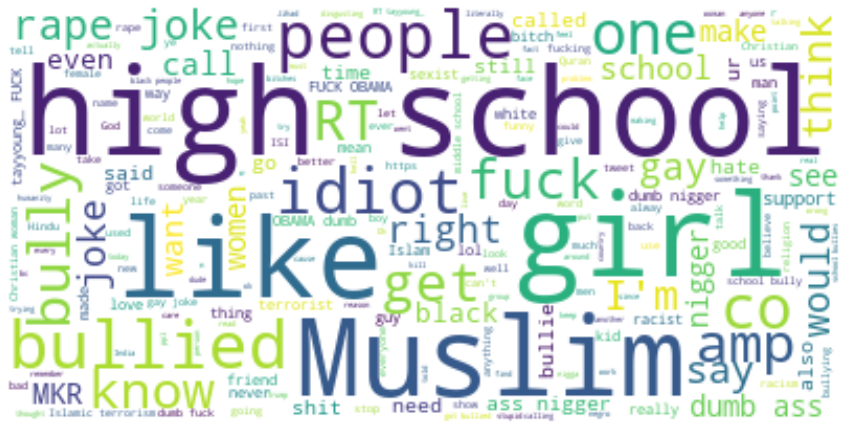

In [34]:
# lets plot the Wordscloud

from wordcloud import WordCloud


text = " ".join(i for i in df_pandas_cleaned.tweet_text)
stopwords = english_stopwords
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
not_cyberbullying_type = cleaned2[cleaned2['cyberbullying_type'] == 'not_cyberbullying'].toPandas()
gender_type = cleaned2[cleaned2['cyberbullying_type'] == 'gender'].toPandas()
religion_type = cleaned2[cleaned2['cyberbullying_type'] == 'religion'].toPandas()
other_cyberbullying_type = cleaned2[cleaned2['cyberbullying_type'] == 'other_cyberbullying'].toPandas()
age_type = cleaned2[cleaned2['cyberbullying_type'] == 'age'].toPandas()
ethnicity_type = cleaned2[cleaned2['cyberbullying_type'] == 'ethnicity'].toPandas()



In [36]:
from collections import Counter

#Top 20 Words in not cyberbullying Tweet
top20 = Counter([item for sublist in religion_type['stop_tokens'] for item in sublist])
type_rc = pd.DataFrame(top20.most_common(10))
type_rc.columns = ['Top of Words', 'Count']
type_rc.style.background_gradient(cmap='Greens')


,Top of Words,Count
0,muslims,2463
1,muslim,2412
2,idiot,1775
3,christian,1544
4,idiots,1347
5,islamic,1288
6,like,1242
7,islam,1241
8,terrorism,1180
9,right,1098


# Evaluate the TF-IDF transform

In [37]:
#########################
tf_encoder = HashingTF(inputCol='stop_tokens', outputCol="tf_enc", numFeatures=2000)  # , numFeatures=10000
tf_enc = tf_encoder.transform(cleaned2)

In [38]:
idf_encoder = IDF(inputCol='tf_enc', outputCol='tf_idf')

In [39]:
idf = idf_encoder.fit(tf_enc).transform(tf_enc)

In [40]:
idf.select("tf_idf").show(6, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tf_idf                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(2000,[209,430,701,926,1257,1426,1924],[4.4674613725956815,3.740603134693424,3.108685040369683,5.989978630469476,4.953207311964649,2.798497480847554,4.881534855240446])                                          |
|(2000,[69,1780],[3.364414486859706,3.132961684665521])                                                                                             

# Vector assembler

In [41]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['tf_idf'],outputCol='features')

In [42]:
assembled = assembler.transform(idf)


In [43]:
assembled.schema.names

['tweet_text',
 'cyberbullying_type',
 'cyberbullying_type_ndx',
 'token_text',
 'stop_tokens',
 'tf_enc',
 'tf_idf',
 'features']

# Pipeline: tokenizer --> stopword removal --> count vector --> idf --> vector assembler

In [44]:
from pyspark.ml import Pipeline

In [45]:
pipeline = Pipeline(stages=[tokenizer, stopremover, tf_encoder, idf_encoder, assembler])

In [46]:
pipe_cleaner = pipeline.fit(indexed)

In [47]:
cleaned = pipe_cleaner.transform(indexed)

In [48]:
cleaned.show()

+--------------------+-------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          tweet_text| cyberbullying_type|cyberbullying_type_ndx|          token_text|         stop_tokens|              tf_enc|              tf_idf|            features|
+--------------------+-------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| &amp; you might ...|             gender|                   4.0|[amp, you, might,...|[amp, might, get,...|(2000,[209,430,70...|(2000,[209,430,70...|(2000,[209,430,70...|
|  I fucking hate you|             gender|                   4.0|[i, fucking, hate...|     [fucking, hate]|(2000,[69,1780],[...|(2000,[69,1780],[...|(2000,[69,1780],[...|
| Keeks is a bitch...|             gender|                   4.0|[keeks, is, a, bi...|[keeks, bitch, cu...|(2000,[201,487,68...|(2000,[201,487,68

In [49]:
data = assembled.select(['features', 'cyberbullying_type_ndx'])


In [50]:
data.tail(10)


[Row(features=SparseVector(2000, {89: 5.1975, 310: 4.3558, 679: 1.7482, 912: 4.1269, 1058: 5.7269, 1149: 10.806, 1209: 2.4266, 1365: 4.6486, 1404: 2.2849, 1941: 6.1876}), cyberbullying_type_ndx=1.0),
 Row(features=SparseVector(2000, {31: 4.9751, 45: 3.6466, 55: 4.2296, 198: 4.1727, 217: 3.5577, 377: 5.631, 451: 3.2843, 833: 5.2586, 926: 2.995, 937: 5.2928, 965: 3.3531, 1169: 4.4356, 1356: 5.631, 1365: 4.6486, 1477: 3.6088, 1513: 4.4505, 1548: 6.177, 1597: 6.058, 1619: 4.1055, 1645: 5.601, 1676: 5.3015, 1798: 5.8036, 1885: 4.2491}), cyberbullying_type_ndx=0.0),
 Row(features=SparseVector(2000, {112: 3.429, 149: 4.6859, 240: 3.6903, 403: 7.002, 488: 3.7839, 524: 3.8261, 539: 3.5142, 545: 6.0961, 557: 2.7132, 750: 4.3905, 784: 6.8188, 815: 2.6277, 940: 3.1865, 946: 4.8093, 1064: 4.7098, 1249: 3.5584, 1329: 4.7622, 1344: 3.716, 1463: 5.7821, 1561: 6.5877, 1594: 3.3345, 1808: 4.6464, 1824: 5.5776, 1939: 3.6032, 1973: 4.9049}), cyberbullying_type_ndx=2.0),
 Row(features=SparseVector(2000, {1

# Training set e test set

In [51]:
training_set, test_set = data.randomSplit([0.7, 0.3], seed=0)

In [52]:
training_set.show(10)

+--------------------+----------------------+
|            features|cyberbullying_type_ndx|
+--------------------+----------------------+
|(2000,[0,1,144,15...|                   4.0|
|(2000,[0,1,166,20...|                   2.0|
|(2000,[0,1,190,31...|                   5.0|
|(2000,[0,4,77,79,...|                   1.0|
|(2000,[0,7,16,70,...|                   0.0|
|(2000,[0,7,21,77,...|                   1.0|
|(2000,[0,7,77,116...|                   1.0|
|(2000,[0,7,165,34...|                   3.0|
|(2000,[0,7,239,27...|                   2.0|
|(2000,[0,9,42,69,...|                   2.0|
+--------------------+----------------------+
only showing top 10 rows



# Random Forest Classifier

In [53]:
from pyspark.ml.classification import RandomForestClassifier as RF

In [54]:
classifier = RF(maxDepth=15, numTrees=100, labelCol="cyberbullying_type_ndx", featuresCol="features", maxMemoryInMB=500, seed=0, impurity='entropy')

In [55]:
model = classifier.fit(training_set)

In [56]:
predictions = model.transform(test_set)

In [57]:
predictions.show()

+--------------------+----------------------+--------------------+--------------------+----------+
|            features|cyberbullying_type_ndx|       rawPrediction|         probability|prediction|
+--------------------+----------------------+--------------------+--------------------+----------+
|(2000,[0,1,33,430...|                   3.0|[11.5915450428828...|[0.11591545042882...|       3.0|
|(2000,[0,2,9,35,4...|                   0.0|[50.2578649702478...|[0.50257864970247...|       0.0|
|(2000,[0,7,77,91,...|                   1.0|[8.82646132248245...|[0.08826461322482...|       1.0|
|(2000,[0,10,83,12...|                   0.0|[34.1294127425117...|[0.34129412742511...|       0.0|
|(2000,[0,10,133,3...|                   4.0|[8.56486787786600...|[0.08564867877866...|       4.0|
|(2000,[0,15,248,3...|                   2.0|[4.01741886088901...|[0.04017418860889...|       2.0|
|(2000,[0,16,56,13...|                   2.0|[13.4060312221966...|[0.13406031222196...|       2.0|
|(2000,[0,

In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as Tester

In [59]:
tester = Tester(predictionCol='prediction', labelCol='cyberbullying_type_ndx')

In [60]:
accuracy = tester.evaluate(predictions)

In [61]:
print(f"Final accuracy is: {accuracy:5.4f}")

Final accuracy is: 0.7602


In [62]:
from sklearn.metrics import classification_report


In [63]:
def make_classification_report(predictions, predCol):
    y_pred = predictions.select(predCol).rdd.collect()
    y_test = predictions.select('cyberbullying_type_ndx').rdd.collect()
    labels = ['religion', 'age', 'ethnicity', 'not_cyberbullying', 'gender', 'other_cyberbullying']
    return print(classification_report(y_test, y_pred, target_names=labels))

In [64]:
make_classification_report(predictions, 'prediction')

#precision: true positive/true positive + false positive
#recall: true positive/true positive + false negative

                     precision    recall  f1-score   support

           religion       0.92      0.92      0.92      2487
                age       0.89      0.99      0.94      2428
          ethnicity       0.93      0.98      0.95      2346
  not_cyberbullying       0.48      0.83      0.61      2301
             gender       0.93      0.74      0.82      2344
other_cyberbullying       0.75      0.10      0.17      1813

           accuracy                           0.79     13719
          macro avg       0.82      0.76      0.73     13719
       weighted avg       0.82      0.79      0.76     13719



# NaiveBayes

In [65]:
from pyspark.ml.classification import NaiveBayes

In [66]:
naive_bayes = NaiveBayes(featuresCol="features", labelCol="cyberbullying_type_ndx", modelType="multinomial")

In [67]:
model = naive_bayes.fit(training_set)

In [68]:
predictions = model.transform(test_set)

In [69]:
predictions.select("cyberbullying_type_ndx", "prediction").show(15)

+----------------------+----------+
|cyberbullying_type_ndx|prediction|
+----------------------+----------+
|                   3.0|       3.0|
|                   0.0|       0.0|
|                   1.0|       1.0|
|                   0.0|       1.0|
|                   4.0|       4.0|
|                   2.0|       2.0|
|                   2.0|       5.0|
|                   4.0|       1.0|
|                   2.0|       5.0|
|                   5.0|       5.0|
|                   0.0|       3.0|
|                   4.0|       4.0|
|                   1.0|       1.0|
|                   0.0|       3.0|
|                   0.0|       0.0|
+----------------------+----------+
only showing top 15 rows



In [70]:
tester = Tester(predictionCol='prediction', labelCol='cyberbullying_type_ndx')

In [71]:
accuracy = tester.evaluate(predictions)

In [72]:
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.7447192638285169
Test Error = 0.255281


In [73]:
make_classification_report(predictions, 'prediction')

                     precision    recall  f1-score   support

           religion       0.83      0.89      0.86      2487
                age       0.81      0.93      0.86      2428
          ethnicity       0.88      0.92      0.90      2346
  not_cyberbullying       0.55      0.46      0.50      2301
             gender       0.83      0.75      0.79      2344
other_cyberbullying       0.49      0.48      0.48      1813

           accuracy                           0.75     13719
          macro avg       0.73      0.74      0.73     13719
       weighted avg       0.74      0.75      0.74     13719



# OneVsRest

In [74]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

In [75]:
lr = LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True, labelCol="cyberbullying_type_ndx",
                        featuresCol="features")

In [76]:
ovr = OneVsRest(classifier=lr, labelCol="cyberbullying_type_ndx", featuresCol="features")

In [77]:
ovrModel = ovr.fit(training_set)

In [78]:
predictions = ovrModel.transform(test_set)

In [79]:
tester = Tester(predictionCol='prediction', labelCol='cyberbullying_type_ndx')

In [80]:
accuracy = tester.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

accuracy = 0.769243
Test Error = 0.230757


In [81]:
make_classification_report(predictions, 'prediction')


                     precision    recall  f1-score   support

           religion       0.84      0.85      0.84      2487
                age       0.90      0.91      0.91      2428
          ethnicity       0.94      0.93      0.94      2346
  not_cyberbullying       0.53      0.57      0.55      2301
             gender       0.84      0.78      0.81      2344
other_cyberbullying       0.51      0.48      0.50      1813

           accuracy                           0.77     13719
          macro avg       0.76      0.76      0.76     13719
       weighted avg       0.77      0.77      0.77     13719



# Cross Validation approach

#### One-vs-Rest

In [83]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True, labelCol="cyberbullying_type_ndx",
                        featuresCol="features")
classifier = OneVsRest(classifier=lr, labelCol="cyberbullying_type_ndx", featuresCol="features")

paramGrid =  ParamGridBuilder() \
    .addGrid(tf_encoder.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()
tester = Tester(predictionCol='prediction', labelCol='cyberbullying_type_ndx', metricName='accuracy')

In [84]:
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=tester,
                          numFolds=5)

In [85]:
cvModel = crossval.fit(data)

In [86]:
predictions = cvModel.transform(data)

In [87]:
make_classification_report(predictions, 'prediction')
print('OnevsRest cross validation accuracy:', tester.evaluate(predictions))

                     precision    recall  f1-score   support

  not_cyberbullying       0.69      0.73      0.71      7840
                age       0.97      0.99      0.98      7988
          ethnicity       0.99      0.98      0.99      7948
           religion       0.96      0.96      0.96      7995
             gender       0.92      0.85      0.88      7867
other_cyberbullying       0.67      0.68      0.67      6107

           accuracy                           0.87     45745
          macro avg       0.87      0.86      0.86     45745
       weighted avg       0.87      0.87      0.87     45745



OnevsRest cross validation accuracy: 0.8715925237730899


#### Random Forest

In [88]:
classifier = RF(labelCol="cyberbullying_type_ndx", seed=0, maxMemoryInMB=500)
paramGrid = ParamGridBuilder()\
    .addGrid(classifier.maxDepth, [15]) \
    .addGrid(classifier.numTrees, [50,100])\
    .build()
tester = Tester(predictionCol='prediction', labelCol='cyberbullying_type_ndx', metricName='accuracy')

In [89]:
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=tester,
                          numFolds=5)

In [90]:
cvModelRF = crossval.fit(data)

In [91]:
predictionsRF = cvModelRF.transform(data)

In [92]:
print('RF cross validation accuracy:', tester.evaluate(predictionsRF))
make_classification_report(predictionsRF, 'prediction')

RF cross validation accuracy: 0.7872554377527599


                     precision    recall  f1-score   support

  not_cyberbullying       0.49      0.86      0.62      7840
                age       0.90      0.99      0.94      7988
          ethnicity       0.94      0.98      0.96      7948
           religion       0.90      0.93      0.91      7995
             gender       0.94      0.74      0.83      7867
other_cyberbullying       0.83      0.06      0.11      6107

           accuracy                           0.79     45745
          macro avg       0.83      0.76      0.73     45745
       weighted avg       0.83      0.79      0.75     45745



### ClassifierPipe

In [82]:
from pyspark.sql import functions


In [83]:

class ClassifierPipe(object):
    "Implementation of an Estimator built by binary and multi classifier in pipeline "

    def __init__(self, binary, multiClassify):  # , multiClassify):
        self.binaryClassify = binary
        self.multiClassify = multiClassify

    def fit_transform(self, train, test, modelB, modelM):
        bin_pred = self.bin_classify(train, test, modelB)  #
        #bin_pred = bin_pred.select('cyberbullying_type_ndx', 'predictionBin', 'features')
        multi_pred = self.multi_classify(train, bin_pred, modelM)
        multi_pred = multi_pred.select('predictionMulti', 'features')
        finalPred = self.assemblePredictions(bin_pred, multi_pred)
        return finalPred

    def bin_classify(self, train, test, modelB ):
        tweets_bin_train, tweets_bin_test = self.binarize(train, test)  # , test_set)
        bin_pred = binaryClassify(tweets_bin_train, tweets_bin_test, modelB)
        bin_pred = bin_pred.select('cyberbullying_type_ndx', 'newlab', 'predictionBin', 'features')
        return bin_pred

    def binarize(self, train, test):  # training_set, test_set): #
        bin_train = train.withColumn("newlab", functions.when(train.cyberbullying_type_ndx == "3", 0).otherwise(1))
        bin_test= test.withColumn("newlab", functions.when(test.cyberbullying_type_ndx == "3", 0).otherwise(1))

        return bin_train, bin_test  # tweets1_train, tweets1_test

    def multi_classify(self, train, test, modelM):
        tweets_training_multi, tweets_test_set_multi = self.preprocess(train, test)
        pred_multi = multiClassify(tweets_training_multi, tweets_test_set_multi, modelM)  #

        return pred_multi

    def preprocess(self, train, pred_bin):
        tweets_training_multi = train.filter(train.cyberbullying_type_ndx != 3) #3 is not_cyberbulling
        tweets_test_set_multi = pred_bin.filter(pred_bin.predictionBin == 1) #1 is generic cyberbullying
        return tweets_training_multi, tweets_test_set_multi

    def assemblePredictions(self, pred_bin, pred_multi):
        finalPred = pred_bin.join(pred_multi, pred_bin.features == pred_multi.features, "left_outer")
        finalPred = finalPred.withColumn('assembledPred', functions.when(isnull(finalPred.predictionMulti), 3).otherwise(
            finalPred.predictionMulti))
        #finalPred= finalPred.withColumn("assembledPred", finalPred.assembledPred.cast('double'))
        return finalPred

    def __call__(self, train, test, modelB, modelM):  # train, test
        res = self.fit_transform(train, test, modelB, modelM)  # (pred_bin,pred_multy)

        return res


In [84]:
def binaryClassify(train, test, model):
    model = model.fit(train)
    predictions = model.transform(test)

    return predictions  #


def multiClassify(train, test, modelM):
    model= modelM.fit(train)
    predictions = model.transform(test)

    return predictions  #



In [85]:
def select_bin_classifier():
    lr= LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True, labelCol="newlab", featuresCol="features",
                            predictionCol='predictionBin')
    nb= NaiveBayes(labelCol='newlab', predictionCol='predictionBin', featuresCol="features" )
    rf= RF(maxDepth=15, numTrees=100, labelCol="newlab", featuresCol="features",
                        predictionCol='predictionBin', seed= 0, impurity= 'entropy')

    classifier={'lr' : lr ,
    'nv': nb,
    'rf' : rf
        }
    return classifier

def select_multi_classifier():
    rf= RF(maxDepth=15, numTrees=100, labelCol="cyberbullying_type_ndx", featuresCol="features",
                      predictionCol='predictionMulti', rawPredictionCol='rawpredictionMulti', probabilityCol='probabilityMulti', seed=0, impurity= 'entropy')
    lr= LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True, labelCol="cyberbullying_type_ndx",
                            featuresCol="features", predictionCol='predictionMulti',
                            rawPredictionCol='rawPredictionMulti', probabilityCol='probabilityMulti'),
    OvsR= OneVsRest(classifier=LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True, labelCol="cyberbullying_type_ndx",
                            featuresCol="features", predictionCol='predictionMulti',
                            rawPredictionCol='rawPredictionMulti', probabilityCol='probabilityMulti'), labelCol="cyberbullying_type_ndx", featuresCol="features",
                          predictionCol='predictionMulti', rawPredictionCol='rawPredictionMulti')
    nb = NaiveBayes(featuresCol="features", labelCol="cyberbullying_type_ndx", modelType="multinomial", predictionCol= "predictionMulti", rawPredictionCol='rawPredictionMulti', probabilityCol='probabilityMulti')
    classifier ={'rf': rf,
    'OvsR': OvsR,
    'nb' : nb}

    return  classifier

In [86]:
bin_classifier= select_bin_classifier()
multi_classifier= select_multi_classifier()


clfPipe = ClassifierPipe(binaryClassify, multiClassify)

In [87]:
print(multi_classifier['nb'])

NaiveBayes_78841649dc1a


In [88]:
predictions_RF_RF = clfPipe.fit_transform(training_set, test_set, modelB= bin_classifier['rf'], modelM=multi_classifier['rf'] )

In [89]:
predictions_RF_OvsR = clfPipe.fit_transform(training_set, test_set, modelB= bin_classifier['rf'], modelM=multi_classifier['OvsR'] )

In [90]:
predictions_RF_NB = clfPipe.fit_transform(training_set, test_set, modelB= bin_classifier['rf'], modelM=multi_classifier['nb'] )

In [106]:
predictions_RF_RF.show()

+----------------------+------+-------------+--------------------+---------------+--------------------+-------------+
|cyberbullying_type_ndx|newlab|predictionBin|            features|predictionMulti|            features|assembledPred|
+----------------------+------+-------------+--------------------+---------------+--------------------+-------------+
|                   3.0|     0|          1.0|(2000,[0,1,33,430...|            5.0|(2000,[0,1,33,430...|          5.0|
|                   0.0|     1|          1.0|(2000,[0,2,9,35,4...|            0.0|(2000,[0,2,9,35,4...|          0.0|
|                   1.0|     1|          1.0|(2000,[0,7,77,91,...|            1.0|(2000,[0,7,77,91,...|          1.0|
|                   0.0|     1|          1.0|(2000,[0,10,83,12...|            1.0|(2000,[0,10,83,12...|          1.0|
|                   4.0|     1|          1.0|(2000,[0,10,133,3...|            4.0|(2000,[0,10,133,3...|          4.0|
|                   2.0|     1|          1.0|(2000,[0,15

In [103]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as Tester
tester = Tester(predictionCol='assembledPred', labelCol='cyberbullying_type_ndx', metricName='accuracy')

In [105]:
print('accuracy RF-RF:', tester.evaluate(predictions_RF_RF))
print('accuracy RF-OvsR:', tester.evaluate(predictions_RF_OvsR))
print('accuracy RF-NB:', tester.evaluate(predictions_RF_NB))

accuracy RF-RF: 0.7592847317744154


accuracy RF-OvsR: 0.7411858394266271


accuracy RF-NB: 0.5455006153623398


In [97]:
make_classification_report(predictions_RF_RF, 'assembledPred')

                     precision    recall  f1-score   support

           religion       0.89      0.93      0.91      2491
                age       0.91      0.99      0.95      2492
          ethnicity       0.92      0.97      0.95      2364
  not_cyberbullying       1.00      0.00      0.00      2303
             gender       0.75      0.83      0.79      2350
other_cyberbullying       0.43      0.80      0.56      1813

           accuracy                           0.76     13813
          macro avg       0.82      0.75      0.69     13813
       weighted avg       0.83      0.76      0.71     13813

